# Quantum Singular Value Transform (QSVT) for matrix inversion

This notebook shows how to solve linear systems of equations using QSVT in PennyLane. The polynomial used corresponds to the polynomial of the QSPPACK package https://github.com/qsppack/QSPPACK.

In [1]:
# import python libraries
import pennylane as qml
from pennylane import numpy as np
from matplotlib import pyplot as plt

# Define linear system

In [2]:
A = np.array(
    [
        [0.65713691, -0.05349524, 0.08024556, -0.07242864],
        [-0.05349524, 0.65713691, -0.07242864, 0.08024556],
        [0.08024556, -0.07242864, 0.65713691, -0.05349524],
        [-0.07242864, 0.08024556, -0.05349524, 0.65713691],
    ]
)

b = np.array([1, 2, 3, 4], dtype="complex")
target_x = np.linalg.inv(A) @ b  # true solution

# Normalize states:
norm_b = np.linalg.norm(b)
b = b / norm_b

norm_x = np.linalg.norm(target_x)
normalized_x = target_x / norm_x

# Define QSVT circuit

In [3]:
def real_u(A, phi, qsvt_wires, deg):
    if deg % 2 == 0:
        phi_even = [-x + np.pi / 2 for x in phi]
        phi_even[0] += np.pi / 4
        phi_even[-1] -= 3 * np.pi / 4
    else:
        phi_even = phi

    qml.Hadamard(wires=qsvt_wires[0])

    qml.ctrl(qml.qsvt(A, phi, qsvt_wires[1:]), control=qsvt_wires[0], control_values=(0,))
    qml.ctrl(qml.qsvt(A.T, phi_even, qsvt_wires[1:]), control=qsvt_wires[0], control_values=(1,))

    qml.Hadamard(wires=qsvt_wires[0])

def qsvt_ls(A, b, phi, qsvt_wires, deg):
    if deg % 4 == 0:
        qml.GlobalPhase(-np.pi / 2)
    elif deg % 4 == 2:
        qml.GlobalPhase(np.pi / 2)
    elif deg % 4 == 3:
        qml.GlobalPhase(-np.pi)
    
    qml.StatePrep(b, wires=qsvt_wires[2:])
    real_u(A.T, phi, qsvt_wires, deg)  # invert the singular values of A transpose to get A^-1

# Find phase angles to approximate $\frac{1}{x}$ with a polynomial

The polynomial is defined by standard QSP operators. The phase angles are provided by the pyqsp library.

In [4]:
# Use precomputed phase angles for kappa=23 and s=1/46

def get_precalculated_angles(degree):
    file_path = 'Phi.txt'

    if degree % 2 == 0 or degree < 1 or degree > 999:
        raise ValueError("Degree is not a precalculated degree. Insert odd number between 1-999.")

    phi_values = []

    with open(file_path, 'r') as file:
        for line in file:
            if f'Degree {degree}:' in line:
                phi_values = [float(value) for value in line.split(':')[1].strip('[] \n').split(',')]
                break

    return phi_values

degree = 555 # odd number up to 999
phi_precalculated = get_precalculated_angles(degree)

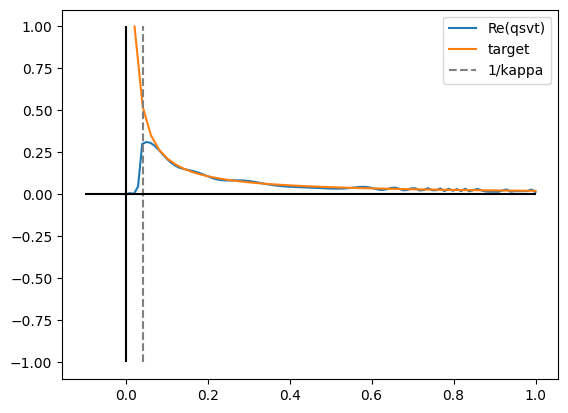

In [5]:
def custom_qsvt(x, phi, wires, deg):
    if deg % 4 == 0:
        qml.GlobalPhase(-np.pi / 2)
    elif deg % 4 == 2:
        qml.GlobalPhase(np.pi / 2)
    elif deg % 4 == 3:
        qml.GlobalPhase(-np.pi)

    qml.qsvt(x, phi, wires)

def plot_poly_QSPPACK(phi, s, kappa, degree):
    x_vals = np.linspace(s, 1, 50)
    inv_x = [s * (1 / x) for x in x_vals]

    samples_x = np.linspace(0, 1, 100)

    qsvt_y_vals = []
    for x in samples_x:
        poly_x = qml.matrix(custom_qsvt, wire_order=[0])(
            x, phi, wires=[0], deg=degree)
        qsvt_y_vals.append(np.real(poly_x[0, 0]))

    plt.plot(samples_x, qsvt_y_vals, label="Re(qsvt)")
    plt.plot(x_vals, inv_x, label="target")

    plt.vlines(1 / kappa, -1.0, 1.0, linestyle="--", color="grey", label="1/kappa")
    plt.vlines(0.0, -1.0, 1.0, color="black")
    plt.hlines(0.0, -0.1, 1.0, color="black")

    plt.legend()
    plt.show()

plot_poly_QSPPACK(phi_precalculated, s=1/46, kappa=23, degree=degree)

# Solve linear system using QSVT

In [6]:
ancilla_wires = [0]
block_wire = [1]
solution_wires = [2, 3]

wires = ancilla_wires + block_wire + solution_wires

dev = qml.device("default.qubit", wires=wires)
@qml.qnode(dev)
def solve_ls(A, b):
    qsvt_ls(A, b, phi_precalculated, wires, degree)

    return qml.state()

In [7]:
# Result by QSVT
qsvt_state = solve_ls(A, b)[:2**len(solution_wires)].real
print(qsvt_state/np.linalg.norm(qsvt_state))

[0.21198391 0.33033183 0.58849131 0.70683922]


In [8]:
# Expected result
print(normalized_x.real)

[0.20539461 0.33532754 0.58192117 0.71185409]


The solutions found by QSVT are close to the expected values (up to a constant).

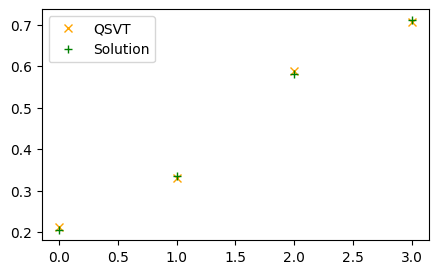

In [9]:
plt.figure(figsize=(5, 3))
plt.plot(qsvt_state/np.linalg.norm(qsvt_state), marker='x', c='orange', label="QSVT", ls="")
plt.plot(normalized_x.real, marker='+', c='green', label="Solution", ls="")
plt.legend()
plt.show()